## Random Forests

In [545]:
% matplotlib inline

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import ensemble
from sklearn.cross_validation import train_test_split, KFold
from sklearn.utils import check_random_state
from sklearn.metrics import log_loss, roc_curve, roc_auc_score, auc

from nose.tools import assert_equal, assert_is_instance, assert_is_not, assert_in
from numpy.testing import assert_array_equal, assert_array_almost_equal
from pandas.util.testing import assert_frame_equal

import warnings
warnings.filterwarnings("ignore")

In [130]:
time_visi.drop_duplicates(inplace=True)

In [133]:
local_visi = match_visibility(time_delayed, time_visi)
local_visi = local_visi.drop(['Time'], axis=1)
print(local_visi.head())

        Month  DayofMonth  CRSDepTime  Delayed  Visibility
398444      1           1        1905        1        10.0
398445      1           2        1905        1         9.0
398446      1           3        1905        1         5.0
398447      1           4        1905        0         7.0
398448      1           5        1905        1        10.0


In [136]:
df = pd.read_csv('2001.csv', encoding='latin-1', usecols=(1, 2, 3, 5, 7, 18))

In [546]:
df = df.loc[local_visi.index, :]
df.loc[local_visi.index, 'Visibility'] = local_visi['Visibility']
df.loc[local_visi.index, 'Delayed'] = local_visi['Delayed']
local = df.reset_index(drop=True) # easier to reset the index in this problem

print(local.head())

   Month  DayofMonth  DayOfWeek  CRSDepTime  CRSArrTime  Distance  Visibility  \
0      1           1          1        1905        2159      1846        10.0   
1      1           2          2        1905        2159      1846         9.0   
2      1           3          3        1905        2159      1846         5.0   
3      1           4          4        1905        2159      1846         7.0   
4      1           5          5        1905        2159      1846        10.0   

   Delayed  
0        1  
1        1  
2        1  
3        0  
4        1  


### Split

In [547]:
def split(df, test_column, test_size, random_state):
    '''
    Uses sklearn.train_test_split to split "df" into a testing set and a test set.
    The "test_columns" lists the column that we are trying to predict.
    All columns in "df" except "test_columns" will be used for training.
    The "test_size" should be between 0.0 and 1.0 and represents the proportion of the
    dataset to include in the test split.
    The "random_state" parameter is used in sklearn.train_test_split.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    test_columns: A list of strings
    test_size: A float
    random_state: A numpy.random.RandomState instance
    
    Returns
    -------
    A 4-tuple of pandas.DataFrames
    '''
    
    x=df.drop(test_column, axis=1)
    y=df[test_column]
    (X_train, X_test, y_train, y_test) = train_test_split(x, y, test_size=test_size,random_state=random_state)
    X_train=np.array(X_train)
    X_test=np.array(X_test)
    y_train=np.array(y_train).flatten()
    y_test=np.array(y_test).flatten()
    return X_train, X_test, y_train, y_test

In [626]:
X_train, X_test, y_train, y_test = split(
    df=local,
    test_column=['Delayed'],
    test_size=0.2,
    random_state=check_random_state(0)
    )

### Use sklearn.KFold

In [549]:
def get_cv_indices(df, n_folds, random_state):
    '''
    Provides train/test indices to split data in train test sets.
    Split dataset into "n_folds" consecutive folds (no shuffling).
    
    Paramters
    ---------
    df: A pandas.DataFrame
    n_folds: integer
    random_state: A numpy.random.RandomState instance

    Returns
    -------
    An sklearn.cross_validation.KFold instance.
    '''
    
    result=KFold(len(df), n_folds=n_folds, random_state=random_state)
    return result

In [550]:
test_kf = get_cv_indices(
    pd.DataFrame({'a': np.arange(1000)}), 10, check_random_state(1)
    )
assert_is_instance(test_kf, KFold)
assert_equal(test_kf.n, 1000)
assert_equal(test_kf.n_folds, 10)
assert_array_equal(test_kf.random_state.choice(100, 5), check_random_state(1).choice(100, 5))

### Random Forest Classifier

In [551]:
def get_rfc(n_estimators, max_features, random_state):
    '''
    A random forest classifier with two adjustable parameters:
    "n_estimators" and "max_features".
    Uses the default sklearn values for the remaining parameters.
    
    Parameters
    ----------
    n_estimators: An int
    max_features: An int
    random_state: A numpy.random.RandomState instance
    
    Returns
    -------
    An sklearn.ensemble.forest.RandomForestClassifier
    '''
    
    rfc = ensemble.RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, random_state=random_state)
    return rfc

In [552]:
test_rfc = get_rfc(100, 10, check_random_state(1))
assert_is_instance(test_rfc, ensemble.RandomForestClassifier)
assert_equal(test_rfc.n_estimators, 100)
assert_equal(test_rfc.max_features, 10)
assert_array_equal(test_rfc.random_state.choice(100, 5), check_random_state(1).choice(100, 5))

### Fit and predict

In [553]:
def get_proba(clf, X_train, y_train, idx_train, idx_valid):
    '''
    
    Fits the "clf" model on X_train[idx_train] and y_train[idx_train].
    Makes predictions on X_train[idx_valid].
    
    Parameters
    ----------
    clf: An sklearn classifier instance.
    X_train: A pandas.DataFrame
    y_train: A pandas.DataFrame
    idx_train: A numpy array
    idx_valid: A numpy array
    
    Returns
    -------
    A two-dimensional numpy array
    '''
    
    x_train=np.array(X_train)
    Y_train=np.array(y_train)
    clf.fit(x_train[idx_train], Y_train[idx_train])
    y_pred=clf.predict_proba(x_train[idx_valid])
    return y_pred

In [554]:
test_X = pd.DataFrame({
    'X0': np.arange(10),
    'X1': np.arange(10),
    'X2': np.arange(10)
    })

test_y = pd.DataFrame({
    'y': np.arange(10)
    })

test_rfc = get_rfc(10, 2, check_random_state(2))

test_proba = get_proba(test_rfc, test_X, test_y,
    np.arange(10)[::2], np.arange(10)[::2] + 1)

assert_array_equal(test_proba,
    np.array(
        [[ 0.6,  0.2,  0.1,  0.1,  0. ],
         [ 0. ,  0.6,  0.3,  0.1,  0. ],
         [ 0. ,  0.2,  0.5,  0.3,  0. ],
         [ 0. ,  0.1,  0.1,  0.5,  0.3],
         [ 0. ,  0.1,  0.1,  0.1,  0.7]])
    )

### Area under the ROC curve

In [587]:
def get_auc(kf, rfc, X_train, y_train):
    '''
    Iterates through the cross-validation folds and
    returns the area under the ROC curve for the validation data.
    
    Parameters
    ----------
    kf: An sklearn.KFold instance
    rfc: An sklearn.RandomForestClassifer instance
    X_train: A pandas.DataFrame
    y_train: A pandas.DataFrame
    
    Returns
    -------
    A numpy array
    '''
    
    result=[]
    for idx_train, idx_valid in kf:
        y_pred=get_proba(rfc, X_train, y_train, idx_train, idx_valid)
        y_test=np.array(y_train)[idx_valid]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
        roc_auc = auc(fpr, tpr)
        result.append(roc_auc)
    return np.array(result)

In [588]:
test_X = pd.DataFrame({
    'X0': np.arange(100),
    'X1': np.arange(100),
    'X2': np.arange(100)
    })

test_y = pd.DataFrame({
    'y': [0, 1] * 50
    })

test_kf = get_cv_indices(test_X, 10, check_random_state(1))

test_rfc = get_rfc(10, 2, check_random_state(2))

test_auc = get_auc(test_kf, test_rfc, test_X, test_y)

assert_array_almost_equal(test_auc,
    [0.5, 0.44, 0.44, 0.4, 0.4, 0.48, 0.48, 0.38, 0.4, 0.5]
    )

### The number of trees

In [589]:
result = []

print('Trees   AUC\n'
      '------------')

for n_trees in range(10, 110, 10):
    kf = get_cv_indices(X_train, 3, check_random_state(0))
    rfc = get_rfc(n_trees, 3, check_random_state(0))
    mean_auc = get_auc(kf, rfc, X_train, y_train).mean()
    result.append((n_trees, mean_auc))
    print('{0:3d}    {1:0.3f}'.format(n_trees, mean_auc))

Trees   AUC
------------
 10    0.702
 20    0.716
 30    0.722
 40    0.726
 50    0.728
 60    0.729
 70    0.730
 80    0.731
 90    0.731
100    0.732


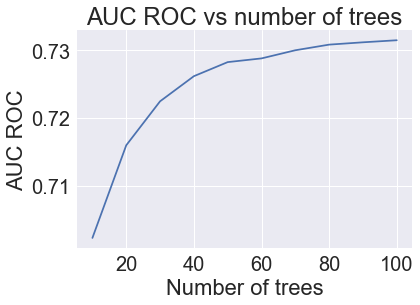

In [590]:
result = np.array(result)
fig, ax = plt.subplots()

ax.plot(result[:, 0], result[:, 1])
ax.set_title('AUC ROC vs number of trees')
ax.set_xlabel('Number of trees')
ax.set_ylabel('AUC ROC')

### Optimize number of features

In [602]:
def optimize_max_features(X_train, y_train, cv_random_state, clf_random_state, n_folds=4, n_trees=20):
    '''
    
    Parameters
    ----------
    X_train: A pandas.DataFrame
    y_train: A pandas.DataFrame
    cv_random_state: A RandomState instance for get_cv_indices()
    clf_random_state: A RandomState instance for get_auc()
    
    Optional
    --------
    n_folds: An int. 4 by default.
    n_trees: An int. 20 by default.
    
    Returns
    --------
    A list of (max_features value, corresponding mean AUC value) tuples.
    '''

    kf =get_cv_indices(X_train, n_folds, cv_random_state)
    result=[]
    for i in range(1,8):
        rfc=get_rfc(n_trees, i, clf_random_state)
        mean_auc=get_auc(kf, rfc, X_train, y_train).mean()
        result.append((i,mean_auc))
    return result      

In [603]:
test_omf = optimize_max_features(X_train[:100], y_train[:100], check_random_state(0), check_random_state(0))
assert_is_instance(test_omf, list)

In [605]:
max_features = optimize_max_features(X_train, y_train, check_random_state(0), check_random_state(0))

In [612]:
best_max_features = np.argmax(np.array(max_features)[:, 1])+1
print('The best value for max_features is {}.'.format(best_max_features))
assert_equal(best_max_features, 5)

The best value for max_features is 5.


### Final Random Forest model

In [615]:
def get_final_rfc(X_train, y_train, X_test, max_features, random_state, n_trees=100):
    '''
    Trains a Random Forest classifier on the entire training set
    using the optimized "max_features".
    Makes probabilistic predictions.
    
    Parameters
    ----------
    X_train: A pandas.DataFrame
    y_train: A pandas.DataFrame
    X_test: A pandas.DataFrame
    max_features: An int
    random_state: A RandomState instance
    
    Optional
    --------
    n_trees: An int. 100 by default
    
    Returns
    -------
    A two-dimensional numpy array
    '''
    
    rfc=get_rfc(n_trees, max_features, random_state)
    x_train=np.array(X_train)
    Y_train=np.array(y_train)
    x_test=np.array(X_test)
    rfc.fit(x_train, Y_train)
    y_pred=rfc.predict_proba(x_test)
    return y_pred

In [616]:
y_pred = get_final_rfc(X_train, y_train, X_test, best_max_features, check_random_state(0))

In [617]:
assert_is_instance(y_pred, np.ndarray)

### Plot ROC curve

In [643]:
def plot_roc_curve(y_test, y_pred):
    '''
    Plots ROC curve with FPR on the x-axis and TPR on the y-axis.
    Displays AUC ROC in the legend.
    
    Paramters
    ---------
    y_test: A pandas.DataFrame
    y_pred: A two dimensional array from get_final_rfc()
    
    Returns
    -------
    A matplotlib.Axes instance
    '''
    
    fig, ax = plt.subplots(figsize=(10,6))
    fpr, tpr, _ = roc_curve(y_test, y_pred[:,1]) 
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Area = 0.73')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    return ax

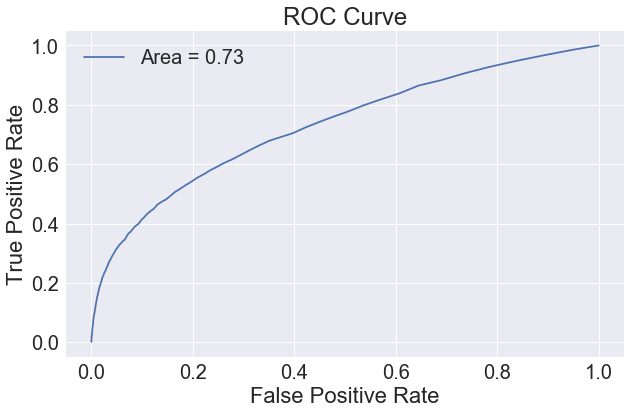

In [644]:
ax = plot_roc_curve(y_test, y_pred)

In [646]:
assert_is_instance(ax, mpl.axes.Axes, msg="Your function should return a matplotlib.axes.Axes object.")

assert_equal(len(ax.lines), 1)

assert_is_not(len(ax.title.get_text()), 0, msg="Your plot doesn't have a title.")
assert_is_not(ax.xaxis.get_label_text(), '', msg="Change the x-axis label to something more descriptive.")
assert_is_not(ax.yaxis.get_label_text(), '', msg="Change the y-axis label to something more descriptive.")
handles, labels = ax.get_legend_handles_labels()
assert_equal('area' in labels[0].lower() or 'auc' in labels[0].lower(), True)
assert_equal('{:0.2f}'.format(roc_auc_score(y_test, y_pred[:, 1])) in labels[0], True)